# Predavanje 3
## Pandas

### Dohvaćanje podataka

Na https://www.hnb.hr/temeljne-funkcije/monetarna-politika/tecajna-lista/tecajna-lista kliknuti Pretraživanje, i odabrati:
* Mjesečni prosjeci
* Sve godine
* Svi mjeseci
* Sve (valute)
* Svi tečajevi
* JSON

te kliknuti "Preuzimanje". Datoteku snimiti u tekući direktorij kao 'HNB tečaj mjesečno.json'.

[CP65001](https://docs.python.org/3.5/library/codecs.html?highlight=cp65001#standard-encodings) je Microsoftova implementacija UTF8.

In [101]:
import pandas as pd
tečaj = pd.read_json('HNB tečaj mjesečno.json', encoding='cp65001')
tečaj.columns

Index(['Država', 'Godina', 'Jedinica', 'Kupovni za devize', 'Mjesec',
       'Prodajni za devize', 'Srednji za devize', 'Valuta', 'Šifra valute'],
      dtype='object')

Vidimo listu stupaca. Mnoge od njih mogli bismo ljepše prikazati. Za početak pogledajmo stupac 'Mjesec'.

### Sređivanje datumâ

In [102]:
hr_mjeseci = set(tečaj['Mjesec'])
hr_mjeseci

{'Kolovoz',
 'Lipanj',
 'Listopad',
 'Ožujak',
 'Prosinac',
 'Rujan',
 'Siječanj',
 'Srpanj',
 'Studeni',
 'Svibanj',
 'Travanj',
 'Veljača'}

Dakle, imamo hrvatske nazive mjeseci. Ako bismo željeli to pretvoriti u datume, trebat će nam broj mjeseca. Python [zna](http://strftime.org/) hrvatske nazive za mjesece, samo trebamo prethodno [locale](https://en.wikipedia.org/wiki/Locale_(computer_software%29) podesiti na hrvatski. Nakon toga izgradimo rječnik koji preslikava nazive mjeseci u njihove redne brojeve.

In [103]:
import locale, time
locale.setlocale(locale.LC_ALL, 'hr')
mjesec_broj = {hr_mjesec: time.strptime(hr_mjesec, '%B').tm_mon for hr_mjesec in hr_mjeseci}
mjesec_broj

{'Kolovoz': 8,
 'Lipanj': 6,
 'Listopad': 10,
 'Ožujak': 3,
 'Prosinac': 12,
 'Rujan': 9,
 'Siječanj': 1,
 'Srpanj': 7,
 'Studeni': 11,
 'Svibanj': 5,
 'Travanj': 4,
 'Veljača': 2}

Sada možemo zamijeniti sve vrijednosti u stupcu 'Mjesec' koristeći gornji rječnik. `inplace` služi tome da se zamjena obavi na licu mjesta, unutar samog dataframea `tečaj` (umjesto vraćanja novog dataframea).

In [104]:
tečaj.replace({'Mjesec': mjesec_broj}, inplace=True)
tečaj.head()

,Država,Godina,Jedinica,Kupovni za devize,Mjesec,Prodajni za devize,Srednji za devize,Valuta,Šifra valute
0,Australija,2011,1,"5,504948",1,"5,538077","5,521513",AUD,36
1,Kanada,2011,1,"5,554872",1,"5,588302","5,571587",CAD,124
2,Češka,2011,1,"0,301385",1,"0,303199","0,302292",CZK,203
3,Danska,2011,1,"0,989672",1,"0,995628","0,992650",DKK,208
4,Mađarska,2011,100,"2,676801",1,"2,692910","2,684856",HUF,348


Sada napokon možemo stvoriti stupac 'Datum' (za dan u mjesecu fiksiramo `1`), te obrisati posebne stupce za godinu i mjesec koji nam više ne trebaju.

In [105]:
tečaj['Datum'] = pd.to_datetime(dict(year=tečaj['Godina'], month=tečaj['Mjesec'], day=1))
del tečaj['Godina'], tečaj['Mjesec']
tečaj.head()

,Država,Jedinica,Kupovni za devize,Prodajni za devize,Srednji za devize,Valuta,Šifra valute,Datum
0,Australija,1,"5,504948","5,538077","5,521513",AUD,36,2011-01-01
1,Kanada,1,"5,554872","5,588302","5,571587",CAD,124,2011-01-01
2,Češka,1,"0,301385","0,303199","0,302292",CZK,203,2011-01-01
3,Danska,1,"0,989672","0,995628","0,992650",DKK,208,2011-01-01
4,Mađarska,100,"2,676801","2,692910","2,684856",HUF,348,2011-01-01


Umjesto beskorisnih rednih brojeva, stavimo datum kao indeks kojim možemo dohvaćati podatke.

In [106]:
tečaj.set_index('Datum', inplace=True)

### Države, valute i šifre

Sada se bacimo na stupce koji se odnose na valutu. Pretpostavljamo da postoji bijekcija (trijekcija?:) između sljedeća 3 stupca:

In [107]:
tečaj[['Država', 'Valuta', 'Šifra valute']].drop_duplicates()

,Država,Valuta,Šifra valute
Datum,,,
2011-01-01,Australija,AUD,36
2011-01-01,Kanada,CAD,124
2011-01-01,Češka,CZK,203
2011-01-01,Danska,DKK,208
2011-01-01,Mađarska,HUF,348
2011-01-01,Japan,JPY,392
2011-01-01,Norveška,NOK,578
2011-01-01,Švedska,SEK,752
2011-01-01,Švicarska,CHF,756


Čini se da je doista tako, jedino što [XDR](https://hr.wikipedia.org/wiki/Posebna_prava_vu%C4%8Denja) nema napisanu državu. Kako euro ima EMU, čini se logičnim XDRu staviti MMF. Šifra valute nam svakako više ne treba, jer je u bijekciji s valutom, a nema neku pametnu semantiku ionako.

In [108]:
tečaj.loc[tečaj['Valuta'] == 'XDR', 'Država'] = 'MMF'
del tečaj['Šifra valute']
tečaj[['Država', 'Valuta']].drop_duplicates()

,Država,Valuta
Datum,,
2011-01-01,Australija,AUD
2011-01-01,Kanada,CAD
2011-01-01,Češka,CZK
2011-01-01,Danska,DKK
2011-01-01,Mađarska,HUF
2011-01-01,Japan,JPY
2011-01-01,Norveška,NOK
2011-01-01,Švedska,SEK
2011-01-01,Švicarska,CHF


Državu zasad ostavimo, ljepše izgleda od troslovne skraćenice valute za kasniju vizualizaciju.

### Tečajevi kao brojevi

Nego, pogledajmo tri stupca sa samim tečajevima. Prvo, maknimo podstring ` za devize` s kraja njihovih naziva. Drugo, pretvorimo ih u brojeve --- samo prethodno moramo decimalni zarez zamijeniti decimalnom točkom (teoretski, o tome bi `locale` trebao voditi računa, ali očito ne funkcionira baš najbolje --- možda jer se ni sami Hrvati ne mogu dogovoriti čime se odvajaju decimale:). I treće, pretvorimo ove retke što imaju `100` u stupcu `Jedinica`, u retke sa 100 puta manjim tečajevima.

In [109]:
tečaj['Jedinica'].drop_duplicates()

Datum
2011-01-01      1
2011-01-01    100
Name: Jedinica, dtype: int64

In [110]:
tečaj.rename(columns=lambda x: x[:-len(' za devize')] if x.endswith(' za devize') else x, inplace=True)
for vrsta in 'Kupovni', 'Prodajni', 'Srednji':
    tečaj[vrsta] = pd.to_numeric(tečaj[vrsta].str.replace(',', '.'))
    tečaj[vrsta] /= tečaj['Jedinica']
del tečaj['Jedinica']
tečaj.head()

,Država,Kupovni,Prodajni,Srednji,Valuta
Datum,,,,,
2011-01-01,Australija,5.504948,5.538077,5.521513,AUD
2011-01-01,Kanada,5.554872,5.588302,5.571587,CAD
2011-01-01,Češka,0.301385,0.303199,0.302292,CZK
2011-01-01,Danska,0.989672,0.995628,0.992650,DKK
2011-01-01,Mađarska,0.026768,0.026929,0.026849,HUF


### Srednji tečaj je dovoljan

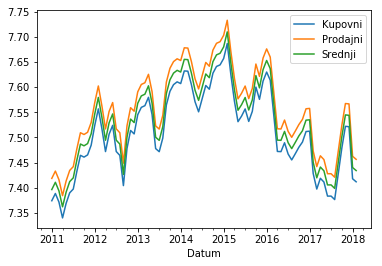

In [111]:
%matplotlib inline
tečaj[tečaj['Valuta'] == 'EUR'].plot()

Iz grafa zaključujemo da su kupovni, srednji i prodajni tečajevi vrlo slični, te nam vjerojatno ne trebaju sva tri podatka (iz bilo kojeg možemo zaključiti ostala dva). Kako XDR nema kupovni i prodajni tečaj, želimo srednji tečaj proglasiti osnovnim, a kupovni i prodajni računati iz njega.

In [112]:
tečaj[tečaj['Valuta'] == 'XDR'].head()

,Država,Kupovni,Prodajni,Srednji,Valuta
Datum,,,,,
2011-01-01,MMF,NaN,NaN,8.575765,XDR
2011-02-01,MMF,NaN,NaN,8.486219,XDR
2011-03-01,MMF,NaN,NaN,8.351255,XDR
2011-04-01,MMF,NaN,NaN,8.158269,XDR
2011-05-01,MMF,NaN,NaN,8.214160,XDR


Prva, relativno očita, hipoteza je da "srednji" tečaj doista znači sredinu, konkretno aritmetičku sredinu.

In [113]:
(tečaj[['Kupovni', 'Prodajni']].mean(axis=1) - tečaj['Srednji']).abs().max()

5.00000002290335e-07

Odstupanje od $5\cdot10^{-7}$ je očito samo posljedica zaokruživanja (jer su tečajevi zaokruženi na 6 decimala).

Ipak, to nije dovoljno da rekonstruiramo i kupovni i prodajni tečaj iz srednjeg --- moramo ustanoviti kolika je razlika. Apsolutna razlika vjerojatno nema smisla, između ostalog jer su neki tečajevi bili dijeljeni sa 100. Pogledajmo relativnu razliku, odnosno omjer.

In [114]:
pd.DataFrame({vrsta: tečaj[vrsta] / tečaj['Srednji'] for vrsta in ['Kupovni', 'Prodajni']}).describe()

,Kupovni,Prodajni
count,1.121000e+03,1.121000e+03
mean,9.970000e-01,1.003000e+00
std,4.673557e-07,4.681532e-07
min,9.969968e-01,1.002997e+00
25%,9.969999e-01,1.003000e+00
50%,9.970000e-01,1.003000e+00
75%,9.970001e-01,1.003000e+00
max,9.970032e-01,1.003002e+00


std (standardna devijacija) od $<5\cdot10^{-7}$ pokazuje da su stupci zapravo konstantni. Vidimo da je razlika 3% u svakom smjeru: kupovni je 3% manji, a prodajni 3% veći od srednjeg. Iz toga slijedi da ih lako možemo rekonstruirati, te ih ne moramo pamtiti kao zasebne stupce u tablici.

In [115]:
del tečaj['Prodajni'], tečaj['Kupovni']

### Grafovi

Pogledajmo primjer grafičkog prikaza: kretanje tečaja švicarskog franka kroz praćeno razdoblje. Jasno se vidi ogromni skok početkom 2015. godine.

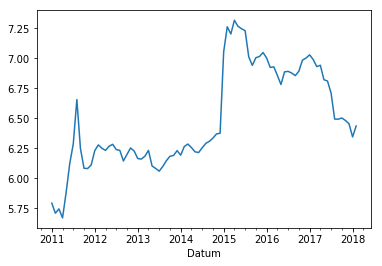

In [116]:
tečaj[tečaj['Valuta'] == 'CHF']['Srednji'].plot()

Možemo napraviti i grafove za svaku pojedinu valutu:

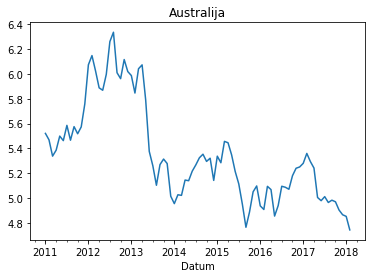

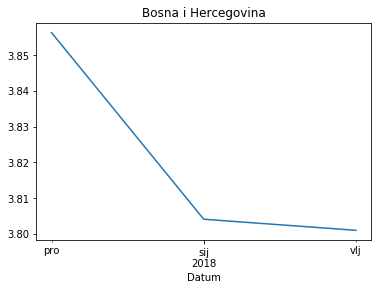

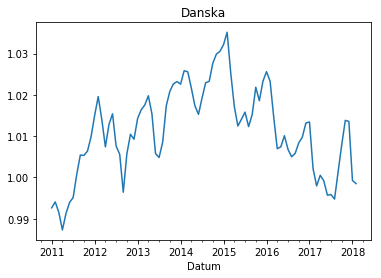

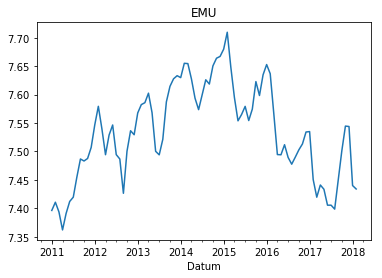

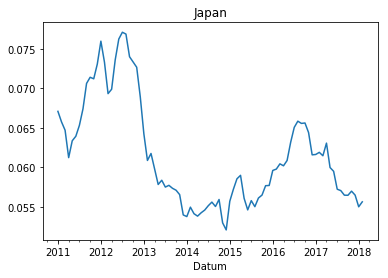

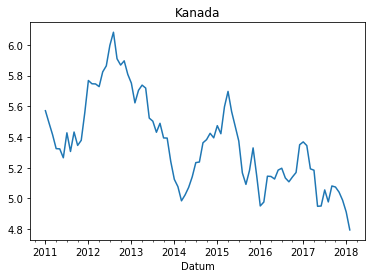

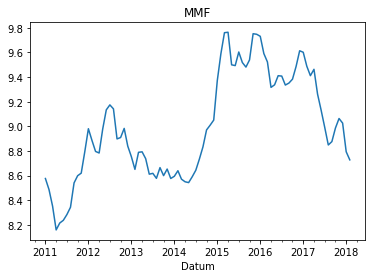

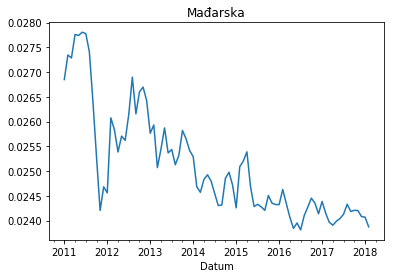

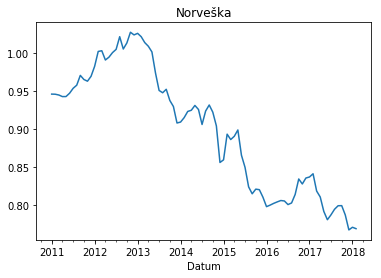

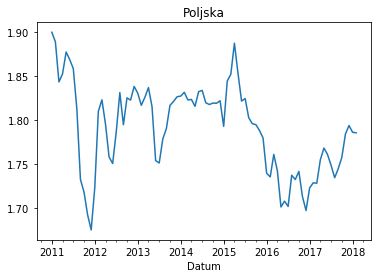

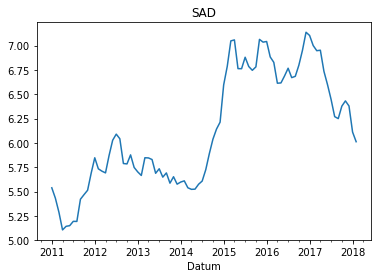

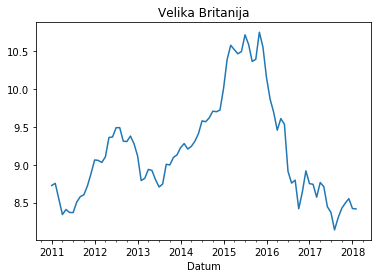

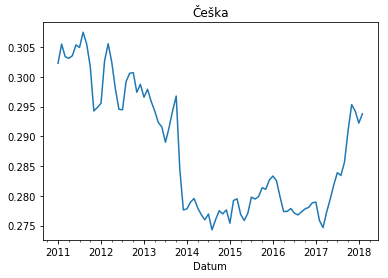

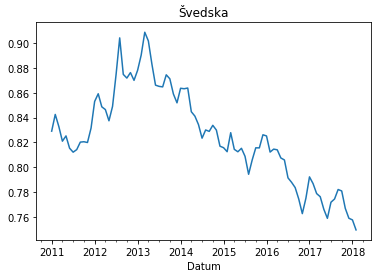

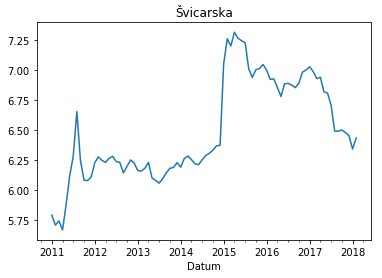

In [117]:
for država, podokvir in tečaj.groupby('Država'): podokvir.plot(title=država, legend=None)

### Odnos dviju stranih valuta

Da bismo pratili relativni tečaj dviju valuta od kojih nijedna nije kuna, potrebno je različite valute dobiti kao stupce. Jednostavan način da se to učini je staviti valutu u indeks (maknut ćemo državu da nam ne smeta), i onda pozvati `unstack` metodu.

In [118]:
tečaj.set_index([tečaj.index, 'Valuta'], inplace=True)
del tečaj['Država']
tečaj.head(20)

Srednji
Datum      Valuta          
2011-01-01 AUD     5.521513
           CAD     5.571587
           CZK     0.302292
           DKK     0.992650
           HUF     0.026849
           JPY     0.067089
           NOK     0.945634
           SEK     0.829051
           CHF     5.794304
           GBP     8.724773
           USD     5.537878
           XDR     8.575765
           EUR     7.396420
           PLN     1.900072
2011-02-01 AUD     5.469563
           CAD     5.492327
           CZK     0.305517
           DKK     0.994092
           HUF     0.027346
           JPY     0.065763

In [119]:
tečaj = tečaj['Srednji'].unstack('Valuta')
tečaj.head()

Valuta,AUD,BAM,CAD,CHF,CZK,DKK,EUR,GBP,HUF,JPY,NOK,PLN,SEK,USD,XDR
Datum,,,,,,,,,,,,,,,
2011-01-01,5.521513,NaN,5.571587,5.794304,0.302292,0.992650,7.396420,8.724773,0.026849,0.067089,0.945634,1.900072,0.829051,5.537878,8.575765
2011-02-01,5.469563,NaN,5.492327,5.710786,0.305517,0.994092,7.410873,8.753128,0.027346,0.065763,0.945485,1.889289,0.842513,5.431365,8.486219
2011-03-01,5.338322,NaN,5.415269,5.746383,0.303387,0.991520,7.393749,8.546276,0.027285,0.064709,0.944455,1.843635,0.832785,5.285354,8.351255
2011-04-01,5.386425,NaN,5.324651,5.671406,0.303116,0.987303,7.362212,8.340644,0.027759,0.061243,0.942367,1.852690,0.820994,5.105235,8.158269
2011-05-01,5.499733,NaN,5.323025,5.882541,0.303557,0.991288,7.391226,8.407499,0.027741,0.063371,0.942421,1.877661,0.825230,5.142271,8.214160


Sada možemo grafički prikazati recimo kretanje tečaja €/\$.

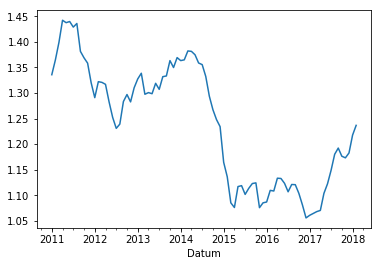

In [120]:
(tečaj['EUR'] / tečaj['USD']).plot()

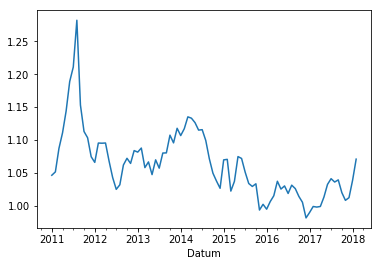

In [121]:
(tečaj['CHF'] / tečaj['USD']).plot()